# Gerando a matriz A e o vetor b
Seja a matriz A e o vetor b das formas:

$$A = 
\begin{bmatrix}
9 & -4 & 1 & 0 & \cdots & \cdots & 0\\
-4 & 6 & -4 & 1 & \ddots & & \vdots\\
1 & -4 & 6 & -4 & 1 & \ddots & \vdots\\
0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0\\
\vdots & \ddots & 1 & -4 & 6 & -4 & 1\\
\vdots & & \ddots & 1 & -4 & 5 & -2\\
0 & \cdots & \cdots & 0 & 1 & -2 & 1\\
\end{bmatrix}, b = 
\begin{bmatrix}
n^{-4}\\
n^{-4}\\
\vdots\\
\vdots\\
\vdots\\
n^{-4}\\
n^{-4}\\
\end{bmatrix}
$$

Podemos gerá-los para um $n$ qualquer da seguinte forma:

In [1]:
import numpy as np

In [2]:
# cria uma matriz A e um vetor b da forma pre-definida
def generate_matrix(n=100):
    A = np.zeros((n, n)) # cria matrix A nxn

    # preenche as 5 diagonais
    np.fill_diagonal(A, 6)
    np.fill_diagonal(A[:-1, 1:], -4)
    np.fill_diagonal(A[1:, :-1], -4)
    np.fill_diagonal(A[:-2, 2:], 1)
    np.fill_diagonal(A[2:, :-2], 1)

    # preenche valores diferentes
    A[0, 0] = 9
    A[-1, -1] = 1
    A[-2, -2] = 5
    A[-2, -1] = -2
    A[-1, -2] = -2
    
    # cria o vetor b
    b = np.full((n, 1), n**-4)
    
    return A, b

# Decomposição de Cholesky

Uma matriz $A$ simétrica e definida positiva pode ser decomposta na forma:
$$A = GG^T$$

Em que $G$ é uma matriz triangular inferior.

## A decomposição

### Elementos diagonais

$$\begin{cases}
g_{11} = \sqrt{a_{11}} \\
g_{ii} = \sqrt{a_{ii} - \sum_{k=1}^{i-1}g_{ik}^2}, i = 2, 3, \cdots, n\\
\end{cases} $$

### Elementos não diagonais

$$\begin{cases}
g_{i1} = \frac{a_{i1}}{g_{11}}, i = 2, 3, \cdots, n\\
g_{ij} = \frac{a_{ij} - \sum_{k=1}^{j-1}g_{ik}g_{jk}}{g_{jj}}, 2 < j < i
\end{cases} $$

In [3]:
from math import sqrt

In [4]:
def cholesky_decomposition(A):
    G = np.zeros_like(A)
    n = A.shape[0]
    
    G[0,0] = sqrt(A[0,0])
    for i in range(1, n):
        G[i,0] = A[i,0] / G[0,0]
        for j in range(1, i):
            sum = 0
            for k in range(j):
                sum += G[i,k]*G[j,k]
            G[i,j] = A[i,j] - sum
            G[i,j] /= G[j,j]
        sum = 0
        for k in range(i):
            sum += G[i,k]**2
        G[i,i] = sqrt(A[i,i] - sum)
    return G

### Verificação

Para uma matriz ser decomposta pela decomposição de Cholesky, ela deve ser simétrica e definida positiva. Podemos testar isso da seguinte forma:

In [5]:
# verifica se uma matriz é simétrica, com um erro definido
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

# verifica se a matriz é simétrica e definida positiva
def check_cholesky(A):
    return check_symmetric(A) and np.all(np.linalg.eigvals(A) > 0)

## Resolução de Sistemas

Para resolver um sistema do tipo $Ax = b$ com decomposição de Cholesky, pode-se fazer como na decomposição L.U:

$$Ax = b\\
(GG^T)x = b\\
Gy = b\\
G^Tx = y$$

De modo a simplificar as contas, afinal $G$ é uma matriz triangular inferior e $G^T$ uma matriz triangular superior.

In [6]:
# resolve A * x = b, em que A é uma matriz triangular inferior
def lower_solve(A, b):
    n = A.shape[0]
    for k in range(1, n):
        b[k] -= A[k, 0:k].dot(b[0:k])
    return b

# resolve A * x = b, em que A é uma matriz triangular superior
def upper_solve(A, b):
    n = A.shape[0]
    for k in range(n-1, -1, -1):
        b[k] -= A[k, k+1:n].dot(b[k+1:n])
        b[k] /= A[k,k]
    return b

# resolve Ax = b por decomposição de cholesky
def cholesky_solve(A, b):
    G1 = cholesky_decomposition(A)
    G2 = G1.T
    
    # divide em duas resoluções de sistema
    y = lower_solve(G1, b)
    x = upper_solve(G2, y)
    
    # retorna o resultado
    return x

Dessa forma, o sistema enunciado previamente pode ser resolvido.

In [7]:
A, b = generate_matrix()
x_cholesky = cholesky_solve(A, b)

# Métodos Interativos

### Objetivo
Queremos definir um processo iterativo, de modo que a sequência de vetores {${x^{(0)}, x^{(1)}, x^{(2)}, \cdots}$} produzida por este processo convirja para a solução $x$, independentemente do chute inicial $x^{(0)} \in \mathbb{R}^n$.

### Critérios de Parada

Podem ser escolhidos diversos critérios de parada. Dados $\epsilon > 0$ e $K_{max} \in \mathbb{N}$

#### Erro absoluto
$$ || x^{(k+1)} - x^{(k)} || < \epsilon $$

#### Erro relativo
$$ \frac{|| x^{(k+1)} - x^{(k)} ||}{||x^{(k+1)}||} < \epsilon $$

#### Teste do resíduo
$$ || b - Ax^{(k)}|| < \epsilon $$

#### Número máximo de iterações
$$ while(k < K_{max}) $$

## Método de Gauss-Jacobi

Dado $Ax = b$ e supondo sem perda de generalidade que $a_{ii} \neq 0$, com $i = 1,\cdots,n$, temos:

$$\begin{cases}
a_{11}x_1 + a_{12}x_2 + \cdots + a_{1n}x_n = b_1 \\
a_{21}x_1 + a_{22}x_2 + \cdots + a_{2n}x_n = b_2 \\
\vdots \\
a_{n1}x_1 + a_{n2}x_2 + \cdots + a_{nn}x_n = b_n \\
\end{cases} $$

A forma do método de Gauss-Jacobi transforma $Ax = b$ em $x = Cx + g$ isolando cada coordenada $x_i$ do vetor $x$

$$\begin{cases}
x^{(k+1)}_1 = \frac{b_1 - a_{12}x^{(k)}_2 - a_{13}x^{(k)}_3 - \cdots - a_{1n}x^{(k)}_n}{a_{11}} \\
x^{(k+1)}_2 = \frac{b_2 - a_{21}x^{(k)}_1 - a_{23}x^{(k)}_3 - \cdots - a_{2n}x^{(k)}_n}{a_{22}} \\
\vdots \\
x^{(k+1)}_n = \frac{b_n - a_{n1}x^{(k)}_1 - a_{n2}x^{(k)}_2 - \cdots - a_{n-1 n-1}x^{(k)}_{n-1}}{a_{nn}} \\
\end{cases} $$

Desta forma, temos um sistema equivalente $x = Cx + g$ em que:

$$C = \begin{bmatrix}
0 & -\frac{a_{12}}{a_{11}} & \cdots & -\frac{a_{1n}}{a_{11}} \\
-\frac{a_{21}}{a_{22}} & 0 & \vdots & -\frac{a_{2n}}{a_{22}} \\
\vdots & \ddots & \ddots & \vdots \\
-\frac{a_{n1}}{a_{nn}} & \cdots & 0 & -\frac{a_{2n}}{a_{22}} \\
\end{bmatrix}, g = \begin{bmatrix}
\frac{b_1}{a_{11}} \\
\frac{b_2}{a_{22}} \\
\vdots \\
\frac{b_n}{a_{nn}} \\
\end{bmatrix}$$

Vamos mostrar como obter $x^{(k+1)} = Cx^{(k)} + g$ a partir de $Ax = b$.

Seja D uma matriz diagonal, formada pela diagonal de A.

$$Ax = b \iff (A + D - D)x = b \iff (A - D)x + Dx = b$$

Dessa forma,

$$ (A - D)x^{(k)} + Dx^{(k+1)} = (D - A)x^{(k)} + b $$

Portanto,

$$ x^{(k+1)} = \underbrace{(I - D^{-1}A)}_{C}x^{(k)} + \underbrace{D^{-1}b}_{g} $$

In [8]:
# Resolve o sistema $Ax = b$ pelo método interativo de Gauss-Jacobi e critério de parada do erro relativo
def gauss_jacobi_solve(A, b, EPSILON=1e-8):
    n = A.shape[0]
    x = np.zeros_like(b) # x^{k+1}
    _x = np.full(n, 1)   # x^{k}
    
    D = np.eye(n) * A    
    D_i = np.linalg.inv(D)
    I = np.eye(n)
    
    C = I - D_i @ A
    g = D_i @ b
    
    cnt_it = 0
    while np.linalg.norm(x - _x)/np.linalg.norm(x) > EPSILON:
        _x = x
        x = C @ x + g
        cnt_it += 1

    return x, cnt_it

## Método de Gauss-Seidel

Tentaremos agora acelerar a convergência do Método de Gauss-Jacobi. No cálculo de $x_i^{(k+1)}$, usaremos os valores já calculados $x_j^{(k+1)}, j < i$ os valores que ainda não foram calculados $x_j^{(k)}, j > i$.


$$\begin{cases}
x^{(k+1)}_1 = \frac{b_1 - a_{12}x^{(k)}_2 - a_{13}x^{(k)}_3 - \cdots - a_{1n}x^{(k)}_n}{a_{11}} \\
x^{(k+1)}_2 = \frac{b_2 - a_{21}x^{(k+1)}_1 - a_{23}x^{(k)}_3 - \cdots - a_{2n}x^{(k)}_n}{a_{22}} \\
\vdots \\
x^{(k+1)}_n = \frac{b_n - a_{n1}x^{(k+1)}_1 - a_{n2}x^{(k+1)}_2 - \cdots - a_{n-1 n-1}x^{(k+1)}_{n-1}}{a_{nn}} \\
\end{cases} $$

Para obter $x^{(k+1)} = Cx^{(k)} + g$ a partir de $Ax + b$, primeiramente consideremos $A = L + R$, em que $L$ é a matriz triangular inferior de $A$ e $R$ é a matriz triangular superior sem a diagonal principal. Assim:

$$Ax = b \iff (L+R)x = b \iff Lx + Rx = b$$

Dessa forma,
$$Lx^{(k+1)} + Rx^{(k)} = b \iff Lx^{(k+1)} = -Rx^{(k)} + b$$

Portanto,

$$ x^{(k+1)} = \underbrace{(-L^{-1}R)}_{C}x^{(k)} + \underbrace{L^{-1}b}_{g} $$

In [9]:
# Resolve o sistema $Ax = b$ pelo método interativo de Gauss-Seidel e critério de parada do erro relativo
def gauss_seidel_solve(A, b, EPSILON=1e-8):
    n = A.shape[0]
    x = np.zeros_like(b) # x^{k+1}
    _x = np.full(n, 1)   # x^{k}
    
    L = np.tril(A)
    R = np.triu(A, 1)
    
    L_i = np.linalg.inv(L)
    C = -L_i @ R
    g = L_i @ b
    
    cnt_it = 0
    while np.linalg.norm(x - _x)/np.linalg.norm(x) > EPSILON:
        _x = x
        x = C @ x + g
        cnt_it += 1
        
    return x, cnt_it

Com isso, o sistema enunciado também pode ser resolvido pelos métodos interativos de Gauss-Jacobi e Gauss-Seidel:

In [227]:
A, b = generate_matrix(100)
x_gjacobi, _ = gauss_jacobi_solve(A, b)

A, b = generate_matrix(100)
x_gseidel_t = gauss_seidel_solve(A, b)

### Critério de Parada utilizado

O critério de parada utilizado foi o de erro relativo, e convergiu após XXX iterações.

### Comparação com o método direto (Cholesky)

Em relação ao método direto de Cholesky, ....

Pode-se calcular o tempo e a quantidade de iterações levados por cada algoritmo pelos métodos a seguir. Eles realizam a chamada das operações *qtt_repeats* vezes, e calculam o tempo médio de execução.

In [10]:
# Modificação do timeit para retornar também o retorno da função chamada
# no caso, retornara a quantidade de iteracoes realizadas nos metodos de gauss jacobi e gauss seidel
# no caso de cholesky, retornara o vetor solucao do sistema (sera ignorado)
import timeit
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}[-1]
    _t1 = _timer()
    return _t1 - _t0, retval
"""

# benchmark do método de cholesky
def cholesky_benchmark(n, qtt_repeats=10):
    A, b = generate_matrix(n)
    t = timeit.Timer(lambda:cholesky_solve(A, b))
    time_info = t.timeit(qtt_repeats)
    return time_info[0]/qtt_repeats

# benchmark do método de gauss jacobi
def gauss_jacobi_benchmark(n, qtt_repeats=10):
    A, b = generate_matrix(n)
    t = timeit.Timer(lambda:gauss_jacobi_solve(A, b))
    time_info = t.timeit(qtt_repeats)
    return time_info[0]/qtt_repeats, time_info[1]/qtt_repeats

# benchmark do método de gauss seidel
def gauss_seidel_benchmark(n, qtt_repeats=10):
    A, b = generate_matrix(n)
    t = timeit.Timer(lambda:gauss_seidel_solve(A, b))
    time_info = t.timeit(qtt_repeats)
    return time_info[0]/qtt_repeats, time_info[1]/qtt_repeats

O tempo levado para resolver o sistema pelo método de Cholesky conforme o $n$ aumenta pode ser observado pelo gráfico abaixo.

In [11]:
import matplotlib.pyplot as plt

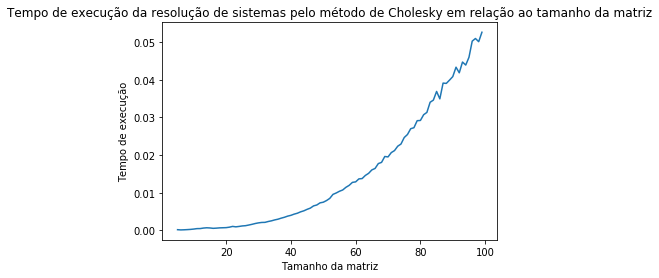

In [12]:
x = [i for i in range(5, 100)]
y = [cholesky_benchmark(i) for i in x]

plt.plot(x, y)
plt.title("Tempo de execução da resolução de sistemas pelo método de Cholesky em relação ao tamanho da matriz")
plt.xlabel("Tamanho da matriz")
plt.ylabel("Tempo de execução")
plt.show()

Análogamente, o tempo de execução em relação ao n pode ser observado nos métodos de Gauss-Jacobi e Gauss-Seidel

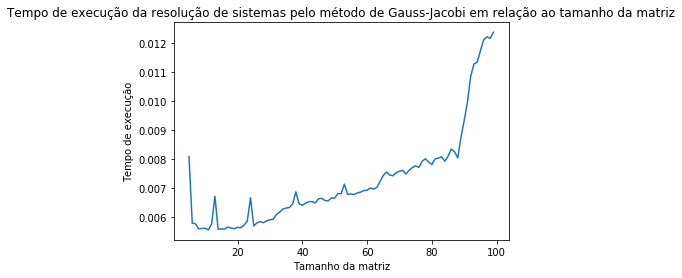

In [13]:
x = [i for i in range(5, 100)]
y = [gauss_jacobi_benchmark(i)[0] for i in x]

plt.plot(x, y)
plt.title("Tempo de execução da resolução de sistemas pelo método de Gauss-Jacobi em relação ao tamanho da matriz")
plt.xlabel("Tamanho da matriz")
plt.ylabel("Tempo de execução")
plt.show()

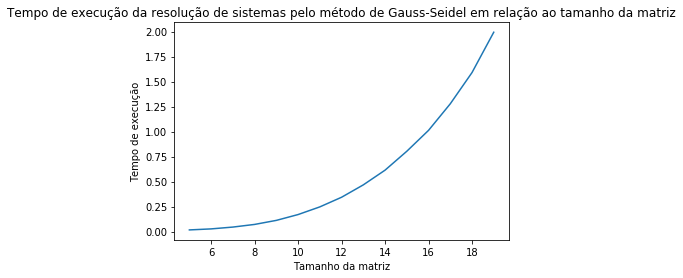

In [14]:
x = [i for i in range(5, 100)]
y = [gauss_seidel_benchmark(i)[0] for i in x]

plt.plot(x, y)
plt.title("Tempo de execução da resolução de sistemas pelo método de Gauss-Seidel em relação ao tamanho da matriz")
plt.xlabel("Tamanho da matriz")
plt.ylabel("Tempo de execução")
plt.show()

A quantidade de interações também pode ser assim analisada:

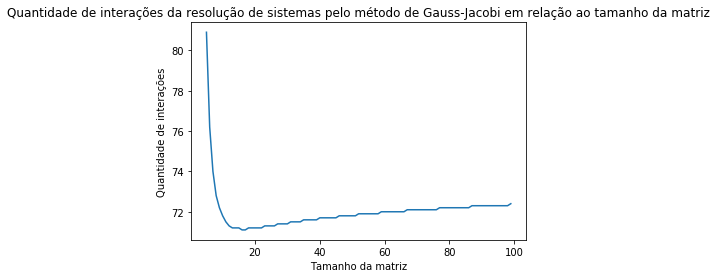

In [15]:
x = [i for i in range(5, 100)]
y = [gauss_jacobi_benchmark(i)[1] for i in x]

plt.plot(x, y)
plt.title("Quantidade de interações da resolução de sistemas pelo método de Gauss-Jacobi em relação ao tamanho da matriz")
plt.xlabel("Tamanho da matriz")
plt.ylabel("Quantidade de interações")
plt.show()

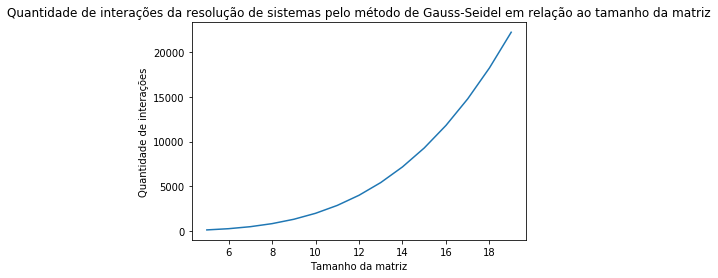

In [17]:
x = [i for i in range(5, 100)]
y = [gauss_seidel_benchmark(i)[1] for i in x]

plt.plot(x, y)
plt.title("Quantidade de interações da resolução de sistemas pelo método de Gauss-Seidel em relação ao tamanho da matriz")
plt.xlabel("Tamanho da matriz")
plt.ylabel("Quantidade de interações")
plt.show()

# Referências

Decomposição de Cholesky: http://wwwp.fc.unesp.br/~arbalbo/Iniciacao_Cientifica/sistemaslineares/teoria/3_Met_Cholesky.pdf

Teste de matriz simetrica em python: https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy